In [6]:
import os
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from parse import *
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RandomForest
import random
from sklearn import linear_model
from datetime import datetime
import gc

pd.set_option("display.max_columns", 2000)


In [2]:
CHUNK_SIZE = 10000

start = datetime.now()

reader_date = pd.read_csv("../train_date.csv",chunksize=CHUNK_SIZE, dtype=np.float32)
reader_num = pd.read_csv("../output/df_id_response.csv",chunksize=CHUNK_SIZE, dtype=np.float32)

#分割して読み込み
loop = 0
cnt_0 = 0
cnt_1 = 0
for df_chunk_date in reader_date:
    df_chunk_num = reader_num.get_chunk(CHUNK_SIZE)
    
    df_chunk = pd.merge(on="Id", left=df_chunk_date, right=df_chunk_num)
    cnt_0 = cnt_0 + len(df_chunk[df_chunk['Response'] == 0].index)
    cnt_1 = cnt_1 + len(df_chunk[df_chunk['Response'] == 1].index)

    if loop == 0:
        df = df_chunk
    else:
        df = pd.concat([df, df_chunk])
    
    print("loop : {} / Rows = {}".format(loop, len(df.index)))

    loop = loop + 1

print("0:{}, 1:{}".format(cnt_0, cnt_1))
print("{} -> {}".format(start, datetime.now()))
print("Memory:{}".format(df.memory_usage(index=True).sum()))

loop : 0 / Rows = 10000
loop : 1 / Rows = 20000
loop : 2 / Rows = 30000
loop : 3 / Rows = 40000
loop : 4 / Rows = 50000
loop : 5 / Rows = 60000
loop : 6 / Rows = 70000
loop : 7 / Rows = 80000
loop : 8 / Rows = 90000
loop : 9 / Rows = 100000
loop : 10 / Rows = 110000
loop : 11 / Rows = 120000
loop : 12 / Rows = 130000
loop : 13 / Rows = 140000
loop : 14 / Rows = 150000
loop : 15 / Rows = 160000
loop : 16 / Rows = 170000
loop : 17 / Rows = 180000
loop : 18 / Rows = 190000
loop : 19 / Rows = 200000
loop : 20 / Rows = 210000
loop : 21 / Rows = 220000
loop : 22 / Rows = 230000
loop : 23 / Rows = 240000
loop : 24 / Rows = 250000
loop : 25 / Rows = 260000
loop : 26 / Rows = 270000
loop : 27 / Rows = 280000
loop : 28 / Rows = 290000
loop : 29 / Rows = 300000
loop : 30 / Rows = 310000
loop : 31 / Rows = 320000
loop : 32 / Rows = 330000
loop : 33 / Rows = 340000
loop : 34 / Rows = 350000
loop : 35 / Rows = 360000
loop : 36 / Rows = 370000
loop : 37 / Rows = 380000
loop : 38 / Rows = 390000
loop 

# station 切り出し

In [7]:
STATION_NUM = 52

date_cols = df.columns

date_feature_list = []

for cur_station_id in range(STATION_NUM):
    date_feature_list_one = []
    for column_name in date_cols:
        if column_name != 'Id':
            r = parse("L{}_S{}_D{}", column_name)
            if r is not None:
                col_line_id    = int(r[0])
                col_station_id = int(r[1])
                
                if cur_station_id == col_station_id:
                    date_feature_list_one.append(column_name)

    date_feature_list.append(date_feature_list_one)

stations_top = []
for st in date_feature_list:
    stations_top.append(st[0])

stations_top

['L0_S0_D1',
 'L0_S1_D26',
 'L0_S2_D34',
 'L0_S3_D70',
 'L0_S4_D106',
 'L0_S5_D115',
 'L0_S6_D120',
 'L0_S7_D137',
 'L0_S8_D145',
 'L0_S9_D152',
 'L0_S10_D216',
 'L0_S11_D280',
 'L0_S12_D331',
 'L0_S13_D355',
 'L0_S14_D360',
 'L0_S15_D395',
 'L0_S16_D423',
 'L0_S17_D432',
 'L0_S18_D437',
 'L0_S19_D454',
 'L0_S20_D462',
 'L0_S21_D469',
 'L0_S22_D543',
 'L0_S23_D617',
 'L1_S24_D677',
 'L1_S25_D1854',
 'L2_S26_D3037',
 'L2_S27_D3130',
 'L2_S28_D3223',
 'L3_S29_D3316',
 'L3_S30_D3496',
 'L3_S31_D3836',
 'L3_S32_D3852',
 'L3_S33_D3856',
 'L3_S34_D3875',
 'L3_S35_D3886',
 'L3_S36_D3919',
 'L3_S37_D3942',
 'L3_S38_D3953',
 'L3_S39_D3966',
 'L3_S40_D3981',
 'L3_S41_D3997',
 'L3_S42_D4029',
 'L3_S43_D4062',
 'L3_S44_D4101',
 'L3_S45_D4125',
 'L3_S46_D4135',
 'L3_S47_D4140',
 'L3_S48_D4194',
 'L3_S49_D4208',
 'L3_S50_D4242',
 'L3_S51_D4255']

# データのあるなし・Max,min を特徴量に追加

In [19]:
df_date_stations = df.loc[:, stations_top]
df_date_max = np.max(df_date_stations, axis=1)
df_date_min = np.min(df_date_stations, axis=1)
df_date_isna = df_date_stations.isna()

#df_date_isna['max'] = df_date_max
#df_date_isna['min'] = df_date_min

df_date_isna.head()

,L0_S0_D1,L0_S1_D26,L0_S2_D34,L0_S3_D70,L0_S4_D106,L0_S5_D115,L0_S6_D120,L0_S7_D137,L0_S8_D145,L0_S9_D152,L0_S10_D216,L0_S11_D280,L0_S12_D331,L0_S13_D355,L0_S14_D360,L0_S15_D395,L0_S16_D423,L0_S17_D432,L0_S18_D437,L0_S19_D454,L0_S20_D462,L0_S21_D469,L0_S22_D543,L0_S23_D617,L1_S24_D677,L1_S25_D1854,L2_S26_D3037,L2_S27_D3130,L2_S28_D3223,L3_S29_D3316,L3_S30_D3496,L3_S31_D3836,L3_S32_D3852,L3_S33_D3856,L3_S34_D3875,L3_S35_D3886,L3_S36_D3919,L3_S37_D3942,L3_S38_D3953,L3_S39_D3966,L3_S40_D3981,L3_S41_D3997,L3_S42_D4029,L3_S43_D4062,L3_S44_D4101,L3_S45_D4125,L3_S46_D4135,L3_S47_D4140,L3_S48_D4194,L3_S49_D4208,L3_S50_D4242,L3_S51_D4255
0,False,False,False,True,False,True,True,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,True,False,True,False,False,True,True,True,True,True,True,True,False,False,True,True,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,False,False,False,True,True,False,False,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,False,False,False,True,False,True,True,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,False,False,True,False,False,True,True,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True


# テストデータ作成

In [20]:
from sklearn.model_selection import train_test_split

start = datetime.now()

## 教師データと訓練データに分離
y = df['Response']
X = df_date_isna

## テストセットと訓練セットに分離
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.head())
print(y_train.head())

print(X_test.head())
print(y_test.head())

print("{} -> {}".format(start, datetime.now()))

      L0_S0_D1  L0_S1_D26  L0_S2_D34  L0_S3_D70  L0_S4_D106  L0_S5_D115  \
7472      True       True       True       True        True        True   
7884      True       True       True       True        True        True   
9721     False      False       True      False       False        True   
55       False      False      False       True       False        True   
7330      True       True       True       True        True        True   

      L0_S6_D120  L0_S7_D137  L0_S8_D145  L0_S9_D152  L0_S10_D216  \
7472        True        True        True        True         True   
7884        True        True        True        True         True   
9721       False        True       False        True        False   
55         False        True       False        True         True   
7330        True        True        True        True         True   

      L0_S11_D280  L0_S12_D331  L0_S13_D355  L0_S14_D360  L0_S15_D395  \
7472         True         True         True         True     

 # 学習

In [21]:
## 学習
import lightgbm as lgb
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.model_selection import GridSearchCV

start = datetime.now()

lgbm = lgb.LGBMClassifier(random_state=1,n_jobs=-1,verbose=2)
parameters = {'max_depth':[3,4,5,6], 'num_leaves':[8,16,32,64]}
mcc_scorer = make_scorer(matthews_corrcoef)
clf = GridSearchCV(lgbm, param_grid=parameters, scoring=mcc_scorer,verbose=2)
clf.fit(X_train, y_train.values.ravel())

print(clf.best_score_)
print(clf.best_params_)

delta = int((datetime.now() - start).total_seconds())
print(">>Execution Time -> {}:{:02}".format(int(delta/60), int(delta % 60)))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=3, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=3, num_leaves=8, total=   2.8s
[CV] max_depth=3, num_leaves=8 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ........................ max_depth=3, num_leaves=8, total=   2.7s
[CV] max_depth=3, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=3, num_leaves=8, total=   2.7s
[CV] max_depth=3, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=3, num_leaves=16, total=   2.9s
[CV] max_depth=3, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ....................... max_depth=3, num_leaves=16, total=   2.7s
[CV] max_depth=3, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=3, num_leaves=16, total=   2.8s
[CV] max_depth=3, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=3, num_leaves=32, total=   2.9s
[CV] max_depth=3, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ....................... max_depth=3, num_leaves=32, total=   2.7s
[CV] max_depth=3, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=3, num_leaves=32, total=   2.7s
[CV] max_depth=3, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=3, num_leaves=64, total=   2.8s
[CV] max_depth=3, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[CV] ....................... max_depth=3, num_leaves=64, total=   2.6s
[CV] max_depth=3, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=3, num_leaves=64, total=   2.7s
[CV] max_depth=4, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=4, num_leaves=8, total=   2.8s
[CV] max_depth=4, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=4, num_leaves=8, total=   2.6s
[CV] max_depth=4, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=4, num_leaves=8, total=   2.7s
[CV] max_depth=4, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=16, total=   3.0s
[CV] max_depth=4, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=16, total=   3.1s
[CV] max_depth=4, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=16, total=   3.0s
[CV] max_depth=4, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=32, total=   3.2s
[CV] max_depth=4, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=32, total=   4.2s
[CV] max_depth=4, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=32, total=   3.0s
[CV] max_depth=4, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=64, total=   3.5s
[CV] max_depth=4, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=64, total=   3.4s
[CV] max_depth=4, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=4, num_leaves=64, total=   3.2s
[CV] max_depth=5, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=5, num_leaves=8, total=   2.8s
[CV] max_depth=5, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=5, num_leaves=8, total=   2.9s
[CV] max_depth=5, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=5, num_leaves=8, total=   2.6s
[CV] max_depth=5, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=16, total=   3.3s
[CV] max_depth=5, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=16, total=   2.8s
[CV] max_depth=5, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=16, total=   3.1s
[CV] max_depth=5, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=32, total=   3.5s
[CV] max_depth=5, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=32, total=   3.3s
[CV] max_depth=5, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=32, total=   3.5s
[CV] max_depth=5, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=64, total=   3.9s
[CV] max_depth=5, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=64, total=   3.8s
[CV] max_depth=5, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=5, num_leaves=64, total=   3.4s
[CV] max_depth=6, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=6, num_leaves=8, total=   2.7s
[CV] max_depth=6, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=6, num_leaves=8, total=   2.7s
[CV] max_depth=6, num_leaves=8 .......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........................ max_depth=6, num_leaves=8, total=   2.7s
[CV] max_depth=6, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=16, total=   3.0s
[CV] max_depth=6, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=16, total=   3.0s
[CV] max_depth=6, num_leaves=16 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=16, total=   2.9s
[CV] max_depth=6, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=32, total=   3.5s
[CV] max_depth=6, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=32, total=   3.6s
[CV] max_depth=6, num_leaves=32 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=32, total=   3.5s
[CV] max_depth=6, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=64, total=   3.8s
[CV] max_depth=6, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=64, total=   3.7s
[CV] max_depth=6, num_leaves=64 ......................................


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....................... max_depth=6, num_leaves=64, total=   3.5s


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.4min finished


0.08297998076813201
{'max_depth': 6, 'num_leaves': 8}
>>Execution Time -> 3:29


C:\Users\Takumi\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


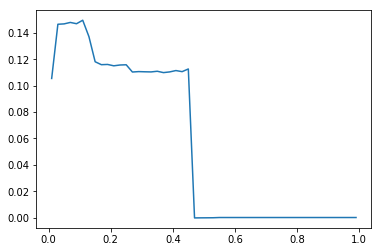

best threshold = 0.11
best mcc = 0.14978365468090066
>>Execution Time -> 0:13


In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

start = datetime.now()

thresholds = np.linspace(0.01,0.99,50)
y_pred = clf.best_estimator_.predict_proba(X_test.values)[:,1]
mcc = np.array([metrics.matthews_corrcoef(y_test.values, y_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
plt.show()

best_thr = thresholds[mcc.argmax()]
print("best threshold = {}".format(best_thr))
print("best mcc = {}".format(mcc.max()))

delta = int((datetime.now() - start).total_seconds())
print(">>Execution Time -> {}:{:02}".format(int(delta/60), int(delta % 60)))

# 全データを用いて再学習

In [24]:
start = datetime.now()
clf_all = lgb.LGBMClassifier(random_state=1,n_jobs=-1,verbose=2, max_depth=clf.best_params_['max_depth'], num_leaves=clf.best_params_['num_leaves'])
clf_all.fit(X, y.values.ravel())
print(">>Execution Time -> {}:{:02}".format(int(delta/60), int(delta % 60)))

>>Execution Time -> 0:13


# テストデータに対する予測

In [25]:
start = datetime.now()
reader_test_date = pd.read_csv("../test_date.csv",chunksize=CHUNK_SIZE)
reader_test_num = pd.read_csv("../test_numeric.csv",chunksize=CHUNK_SIZE)

#分割して読み込み
loop = 0
for df_chunk_test_date in reader_test_date:
    df_chunk_test_num = reader_test_num.get_chunk(CHUNK_SIZE)
    
    df_test_chunk = pd.merge(on="Id", left=df_chunk_test_date, right=df_chunk_test_num)

    
    df_date_stations_chunk = df_test_chunk.loc[:, stations_top]
    df_date_max = np.max(df_date_stations_chunk, axis=1)
    df_date_min = np.min(df_date_stations_chunk, axis=1)
    df_date_isna_chunk = df_date_stations_chunk.isna()
    df_test_id_chunk = df_test_chunk['Id']
    
#    df_date_isna_chunk['max'] = df_date_max
#    df_date_isna_chunk['min'] = df_date_min
    
    ##予測
    ary_test_chunk_pred = clf_all.predict_proba(df_date_isna_chunk.values)[:,1]
    y_submit = ary_test_chunk_pred > best_thr

    df_test_chunk_pred = pd.DataFrame({'Id':df_test_id_chunk.values, 'Response':y_submit})
    
    if loop == 0:
        df_test_pred = df_test_chunk_pred
    else:
        df_test_pred = pd.concat([df_test_pred, df_test_chunk_pred])
    
    print("loop : {} / Rows = {}".format(loop, len(df_test_pred.index)))
    
    loop = loop + 1

df_test_pred['Response'] = df_test_pred.Response.astype('bool')
df_test_pred.head()

loop : 0 / Rows = 10000
loop : 1 / Rows = 20000
loop : 2 / Rows = 30000
loop : 3 / Rows = 40000
loop : 4 / Rows = 50000
loop : 5 / Rows = 60000
loop : 6 / Rows = 70000
loop : 7 / Rows = 80000
loop : 8 / Rows = 90000
loop : 9 / Rows = 100000
loop : 10 / Rows = 110000
loop : 11 / Rows = 120000
loop : 12 / Rows = 130000
loop : 13 / Rows = 140000
loop : 14 / Rows = 150000
loop : 15 / Rows = 160000
loop : 16 / Rows = 170000
loop : 17 / Rows = 180000
loop : 18 / Rows = 190000
loop : 19 / Rows = 200000
loop : 20 / Rows = 210000
loop : 21 / Rows = 220000
loop : 22 / Rows = 230000
loop : 23 / Rows = 240000
loop : 24 / Rows = 250000
loop : 25 / Rows = 260000
loop : 26 / Rows = 270000
loop : 27 / Rows = 280000
loop : 28 / Rows = 290000
loop : 29 / Rows = 300000
loop : 30 / Rows = 310000
loop : 31 / Rows = 320000
loop : 32 / Rows = 330000
loop : 33 / Rows = 340000
loop : 34 / Rows = 350000
loop : 35 / Rows = 360000
loop : 36 / Rows = 370000
loop : 37 / Rows = 380000
loop : 38 / Rows = 390000
loop 

,Id,Response
0,1,False
1,2,False
2,3,False
3,5,False
4,8,False


In [17]:
df_test_pred['Response'] = df_test_pred.Response.astype('bool')
df_test_pred.head()

,Id,Response
0,1,False
1,2,False
2,3,False
3,5,False
4,8,False


# 結果

In [27]:
##CSV出力
y_submit = df_test_pred
y_submit.to_csv("submit_date_is_nan.csv", columns=['Id', 'Response'], index=False)
print(y_submit.Response.sum())

4090


# 0.1479